In [ ]:
import torch
import torchtext
from torchtext import data
import matplotlib.pyplot as plt
import torch.optim as optim
import argparse
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import tensorflow as tf


In [ ]:
df = pd.read_csv('/content/data.tsv', sep="\t")

In [ ]:
display(df)

,text,label
0,"smart and alert , thirteen conversations about...",1
1,"color , musical bounce and warm seas lapping o...",1
2,it is not a mass-market entertainment but an u...,1
3,a light-hearted french film about the spiritua...,1
4,my wife is an actress has its moments in looki...,1
...,...,...
9995,"in the end , they discover that balance in lif...",0
9996,a counterfeit 1000 tomin bank note is passed i...,0
9997,enter the beautiful and mysterious secret agen...,0
9998,after listening to a missionary from china spe...,0


In [ ]:
X = df['text']
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.20,stratify=y_train)

In [ ]:
def create_overfit_set():
  condition_positive = df['label'] == 1
  condition_negative = df['label'] == 0

  positive_set = df[condition_positive].sample(n = 25)
  negative_set = df[condition_negative].sample(n = 25)

  sample_set = [positive_set,negative_set]
  overfit_set = pd.concat(sample_set)
  return overfit_set

In [ ]:
overfit_dataset = create_overfit_set()

In [ ]:
train_dataset = pd.concat([X_train, y_train], axis=1)
val_dataset = pd.concat([X_val, y_val], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)


In [ ]:
train_dataset.to_csv("train.tsv", sep="\t")
val_dataset.to_csv("validation.tsv", sep="\t")
test_dataset.to_csv("test.tsv", sep="\t")
overfit_dataset.to_csv("overfit.tsv", sep="\t")

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "/content/"
        fullpath = os.path.join(data_path, f"{split}.tsv")
        # print(fullpath)
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 

In [ ]:
def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [ ]:
batch_size = 4
#   fix seed
torch.manual_seed(2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)

### 3.3 Processing of the data ###
# 3.3.1
# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                
# # 3.3.2

train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")
overfit_dataset = TextDataset(glove, "overfit")
    
# # 3.3.3
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device))
    
overfit_dataloader = torch.utils.data.DataLoader(
    dataset=overfit_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device))
    
    # for item in train_dataloader:
    #   print(item)
    #   break

Using device: cpu


.vector_cache/glove.6B.zip: 862MB [02:44, 5.25MB/s]                           
100%|█████████▉| 399999/400000 [00:17<00:00, 23264.35it/s]


In [ ]:
def print_closest_cosine_words(vec, n=5):
    cosine = torch.nn.CosineSimilarity(dim=2)
    dists = cosine(glove.vectors.unsqueeze(0), vec.unsqueeze(0))
    dists = dists.squeeze(0)
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1], reverse = True) 
    for idx, difference in lst[1:n+1]:                         
        print(glove.itos[idx], "\t%5.2f" % difference)

In [ ]:
class cnn(torch.nn.Module):
      def __init__(self, vocab, emdedding_size):
        super(cnn,self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors)
        self.cnn_layer1 = torch.nn.Conv2d(1,50,(2,100),1,bias=False)
        self.cnn_layer2 = torch.nn.Conv2d(1,50,(4,100),1,bias=False)
        self.activation = torch.nn.ReLU()
        self.linear = torch.nn.Linear(emdedding_size,1)
      def forward(self, x):
        length = len(x)
        embedded_result = self.embedding(x)
        embedded_result = embedded_result.permute(1,0,2)
        embedded_result = embedded_result.unsqueeze(1)
        cnn_layer1_result = self.cnn_layer1(embedded_result)
        cnn_layer2_result = self.cnn_layer2(embedded_result)
        layer1_activation = self.activation(cnn_layer1_result)
        layer2_activation = self.activation(cnn_layer2_result)
        layer1_activation = layer1_activation.squeeze()
        layer2_activation = layer2_activation.squeeze()
        max_pool_layer1_result = torch.nn.functional.max_pool1d(layer1_activation,int(length-1))
        max_pool_layer2_result = torch.nn.functional.max_pool1d(layer2_activation,int(length-3))
        max_pool_layer1_result = max_pool_layer1_result.squeeze()
        max_pool_layer2_result = max_pool_layer2_result.squeeze()        
        concatenated_result = torch.cat((max_pool_layer1_result,max_pool_layer2_result),1)
        prediction = self.linear(concatenated_result)
        return prediction

In [ ]:
cnn(glove,100)

cnn(
  (embedding): Embedding(400000, 100)
  (cnn_layer1): Conv2d(1, 50, kernel_size=(2, 100), stride=(1, 1), bias=False)
  (cnn_layer2): Conv2d(1, 50, kernel_size=(4, 100), stride=(1, 1), bias=False)
  (activation): ReLU()
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
def train_cnn_model_overfit(dataloader, embedding_size):
    BATCH_SIZE = 4
    epoch = 50
    
    learning_rate = 0.001
    train_set_loss = []
    test_set_loss = []
    t_accuracy = []
    v_accuracy = []
    val_set_loss = []
    val_loss = 0.0
    model = cnn(glove,embedding_size)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),learning_rate)
    print("Training Started ----->")
    iterations = np.arange(0,epoch)
    for epoch in range(epoch):
      train_loss = 0.0
      model.train()
      n1=0
      train_accuracy = 0.0
      for text,label in (iter(dataloader)):
        prediction = model(text)
        prediction = prediction.squeeze(1)
        label = label.type(torch.float)
        loss = criterion(prediction,label)
        loss.backward()
        optimizer.step()
        accuracy = ((prediction>0.5)==label).float().sum()
        train_accuracy = train_accuracy + accuracy/batch_size
        optimizer.zero_grad()
        train_loss = train_loss + (float(loss))
        n1= n1+1
      train_set_loss.append(train_loss/n1)
      t_accuracy.append(train_accuracy/n1)


      print("Epoch [{}], overfit_dataset_loss: {:.4f}, Accuracy: {:.4f}".format(epoch,train_set_loss[-1],t_accuracy[-1]))

    plt.title("Accuracy curve for CNN model - Overfit")
    plt.plot(iterations,t_accuracy,label = "Overfit")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()   

    plt.title("Loss curve for CNN model - Overfit")
    plt.plot(iterations,train_set_loss,label = "Overfit")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show() 

    return model

Training Started ----->
Epoch [0], overfit_dataset_loss: 1.0422, Accuracy: 0.1923
Epoch [1], overfit_dataset_loss: 0.5414, Accuracy: 0.8654
Epoch [2], overfit_dataset_loss: 0.4986, Accuracy: 0.5192
Epoch [3], overfit_dataset_loss: 0.4688, Accuracy: 0.5000
Epoch [4], overfit_dataset_loss: 0.3870, Accuracy: 0.7885
Epoch [5], overfit_dataset_loss: 0.3224, Accuracy: 0.9231
Epoch [6], overfit_dataset_loss: 0.2680, Accuracy: 0.9615
Epoch [7], overfit_dataset_loss: 0.2184, Accuracy: 0.9615
Epoch [8], overfit_dataset_loss: 0.1770, Accuracy: 0.9615
Epoch [9], overfit_dataset_loss: 0.1411, Accuracy: 0.9615
Epoch [10], overfit_dataset_loss: 0.1120, Accuracy: 0.9615
Epoch [11], overfit_dataset_loss: 0.0900, Accuracy: 0.9615
Epoch [12], overfit_dataset_loss: 0.0723, Accuracy: 0.9615
Epoch [13], overfit_dataset_loss: 0.0593, Accuracy: 0.9615
Epoch [14], overfit_dataset_loss: 0.0489, Accuracy: 0.9615
Epoch [15], overfit_dataset_loss: 0.0411, Accuracy: 0.9615
Epoch [16], overfit_dataset_loss: 0.0346, 

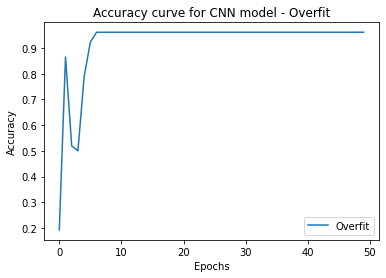

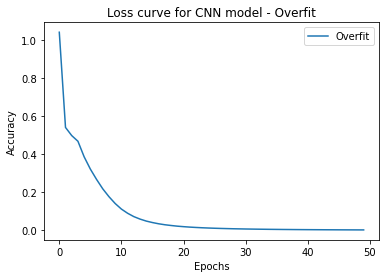

cnn(
  (embedding): Embedding(400000, 100)
  (cnn_layer1): Conv2d(1, 50, kernel_size=(2, 100), stride=(1, 1), bias=False)
  (cnn_layer2): Conv2d(1, 50, kernel_size=(4, 100), stride=(1, 1), bias=False)
  (activation): ReLU()
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
train_cnn_model_overfit(overfit_dataloader,100)

In [ ]:
class cnn(torch.nn.Module):
      def __init__(self, vocab, emdedding_size,k1,k2,n1,n2):
        super(cnn,self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors)
        self.cnn_layer1 = torch.nn.Conv2d(1,n1,(k1,100),1,bias=False)
        self.cnn_layer2 = torch.nn.Conv2d(1,n2,(k2,100),1,bias=False)
        self.activation = torch.nn.ReLU()
        self.linear = torch.nn.Linear(2*n2,1)
      def forward(self, x):
        length = len(x)
        embedded_result = self.embedding(x)
        embedded_result = embedded_result.permute(1,0,2)
        embedded_result = embedded_result.unsqueeze(1)
        cnn_layer1_result = self.cnn_layer1(embedded_result)
        cnn_layer2_result = self.cnn_layer2(embedded_result)
        layer1_activation = self.activation(cnn_layer1_result)
        layer2_activation = self.activation(cnn_layer2_result)
        layer1_activation = layer1_activation.squeeze()
        layer2_activation = layer2_activation.squeeze()
        max_pool_layer1_result = torch.nn.functional.max_pool1d(layer1_activation,int(length-1))
        max_pool_layer2_result = torch.nn.functional.max_pool1d(layer2_activation,int(length-3))
        max_pool_layer1_result = max_pool_layer1_result.squeeze()
        max_pool_layer2_result = max_pool_layer2_result.squeeze()        
        concatenated_result = torch.cat((max_pool_layer1_result,max_pool_layer2_result),1)
        prediction = self.linear(concatenated_result)
        return prediction

In [ ]:
def train_cnn_model(dataloader, embedding_size):
    BATCH_SIZE = 4
    epoch = 15
    
    learning_rate = 0.0001
    train_set_loss = []
    test_set_loss = []
    t_accuracy = []
    v_accuracy = []
    val_set_loss = []
    val_loss = 0.0
    model = cnn(glove,embedding_size,2,4,20,20)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),learning_rate)
    print("Training Started ----->")
    iterations = np.arange(0,epoch)
    for epoch in range(epoch):
      train_loss = 0.0
      model.train()
      n1=0
      train_accuracy = 0.0
      for text,label in tqdm(iter(dataloader)):
        prediction = model(text)
        prediction = prediction.squeeze(1)
        label = label.type(torch.float)
        loss = criterion(prediction,label)
        loss.backward()
        optimizer.step()
        accuracy = ((prediction>0.5)==label).float().sum()
        train_accuracy = train_accuracy + accuracy/batch_size
        optimizer.zero_grad()
        train_loss = train_loss + (float(loss))
        n1= n1+1
      train_set_loss.append(train_loss/n1)
      t_accuracy.append(train_accuracy/n1)
      

      model.eval()
      with torch.no_grad():
        val_loss = 0.0
        val_accuracy = 0.0
        n2=0
        for text,label in iter(dataloader):
          prediction = model(text)
          prediction = prediction.squeeze(1)
          label = label.type(torch.float)
          accuracy = ((prediction>0.5)==label).float().sum()
          val_accuracy = val_accuracy + (accuracy/BATCH_SIZE)
          loss = criterion(prediction,label)
          val_loss = val_loss + (float(loss)/BATCH_SIZE)
          n2= n2+1
        val_set_loss.append(val_loss/n2)
        v_accuracy.append(val_accuracy/n2)

      print("Epoch [{}], train_loss: {:.4f}, Accuracy: {:.4f}".format(epoch,train_set_loss[-1],t_accuracy[-1]))

    plt.title("Accuracy curve for CNN model - Train set with best parameters")
    plt.plot(iterations,t_accuracy,label = "Training")
    plt.plot(iterations,v_accuracy,label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()   

    plt.title("Loss curve for CNN model - Train Set with best parameters")
    plt.plot(iterations,train_set_loss,label = "Training")
    plt.plot(iterations,val_set_loss,label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()  

    return model

Training Started ----->


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.5517, Accuracy: 0.6473


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.3534, Accuracy: 0.8509


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.2951, Accuracy: 0.8739


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.2659, Accuracy: 0.8867


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2456, Accuracy: 0.8972


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.2295, Accuracy: 0.9069


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.2160, Accuracy: 0.9112


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.2043, Accuracy: 0.9178


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1940, Accuracy: 0.9223


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1846, Accuracy: 0.9266


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.1760, Accuracy: 0.9309


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.1679, Accuracy: 0.9347


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.1605, Accuracy: 0.9370


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.1536, Accuracy: 0.9403


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.1470, Accuracy: 0.9448


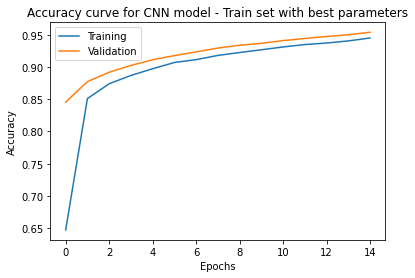

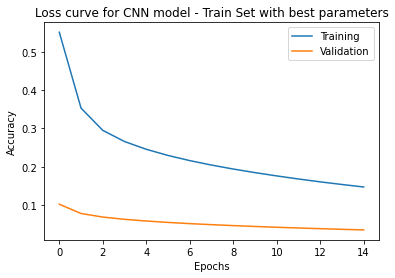

In [ ]:
cnn_model = train_cnn_model(train_dataloader,100)

In [ ]:
class cnn(torch.nn.Module):
      def __init__(self, vocab, emdedding_size,k1,k2,n1,n2):
        super(cnn,self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors,freeze = False)
        self.cnn_layer1 = torch.nn.Conv2d(1,n1,(k1,100),1,bias=False)
        self.cnn_layer2 = torch.nn.Conv2d(1,n2,(k2,100),1,bias=False)
        self.activation = torch.nn.ReLU()
        self.linear = torch.nn.Linear(2*n2,1)
      def forward(self, x):
        length = len(x)
        embedded_result = self.embedding(x)
        embedded_result = embedded_result.permute(1,0,2)
        embedded_result = embedded_result.unsqueeze(1)
        cnn_layer1_result = self.cnn_layer1(embedded_result)
        cnn_layer2_result = self.cnn_layer2(embedded_result)
        layer1_activation = self.activation(cnn_layer1_result)
        layer2_activation = self.activation(cnn_layer2_result)
        layer1_activation = layer1_activation.squeeze()
        layer2_activation = layer2_activation.squeeze()
        max_pool_layer1_result = torch.nn.functional.max_pool1d(layer1_activation,int(length-1))
        max_pool_layer2_result = torch.nn.functional.max_pool1d(layer2_activation,int(length-3))
        max_pool_layer1_result = max_pool_layer1_result.squeeze()
        max_pool_layer2_result = max_pool_layer2_result.squeeze()        
        concatenated_result = torch.cat((max_pool_layer1_result,max_pool_layer2_result),1)
        prediction = self.linear(concatenated_result)
        return prediction

Training Started ----->


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.4856, Accuracy: 0.7331


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.2600, Accuracy: 0.9062


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.2055, Accuracy: 0.9211


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.1794, Accuracy: 0.9320


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.1619, Accuracy: 0.9392


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.1486, Accuracy: 0.9450


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.1378, Accuracy: 0.9497


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1285, Accuracy: 0.9547


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1204, Accuracy: 0.9584


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1131, Accuracy: 0.9611


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.1064, Accuracy: 0.9636


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.1003, Accuracy: 0.9667


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.0946, Accuracy: 0.9686


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.0893, Accuracy: 0.9709


  0%|          | 0/1600 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.0843, Accuracy: 0.9731


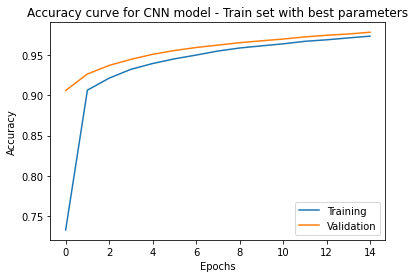

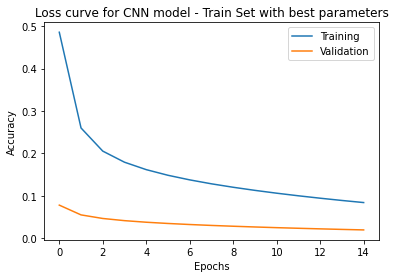

In [ ]:
cnn_model = train_cnn_model(train_dataloader,100)

In [ ]:
def evaluate(dataloader):

  t_accuracy = []
  v_accuracy = []
  val_set_loss = []
  val_loss = 0.0
  criterion = torch.nn.BCEWithLogitsLoss()
  BATCH_SIZE = 4

  cnn_model.eval()
  with torch.no_grad():
    val_loss = 0.0
    val_accuracy = 0.0
    n2=0
    for text,label in iter(dataloader):
      prediction = cnn_model(text)
      prediction = prediction.squeeze(1)
      label = label.type(torch.float)
      accuracy = ((prediction>0.5)==label).float().sum()
      val_accuracy = val_accuracy + (accuracy/BATCH_SIZE)
      loss = criterion(prediction,label)
      val_loss = val_loss + (float(loss)/BATCH_SIZE)
      n2= n2+1
    val_set_loss.append(val_loss/n2)
    v_accuracy.append(val_accuracy/n2)

  print("test_loss: {:.4f}, Accuracy: {:.4f}".format(val_set_loss[-1],v_accuracy[-1]))

In [ ]:
evaluate(test_dataloader)

test_loss: 0.0529, Accuracy: 0.9155


In [ ]:
weights = cnn_model.cnn_layer1.weight

In [ ]:
weights = weights.squeeze()

In [ ]:
weights = torch.mean(weights,1)

In [ ]:
for item in weights:
  print_closest_cosine_words(item.detach(),10)
  print('-------------------------------------------')

worcester 	 0.45
petersburg 	 0.44
f.c. 	 0.43
village 	 0.42
essex 	 0.41
connecticut 	 0.41
maine 	 0.40
durham 	 0.40
seminary 	 0.40
ny 	 0.40
-------------------------------------------
well-acted 	 0.56
well-made 	 0.55
heart-rending 	 0.52
watchable 	 0.52
funnily 	 0.51
non-unique 	 0.51
austenitic 	 0.51
talky 	 0.50
through-composed 	 0.50
referentially 	 0.50
-------------------------------------------
pretentious 	 0.49
facile 	 0.49
inelegant 	 0.48
enjoyably 	 0.48
pleasing 	 0.48
well-acted 	 0.47
sillier 	 0.47
asinine 	 0.47
nuanced 	 0.47
well-made 	 0.47
-------------------------------------------
bbundy 	 0.41
originating 	 0.39
abducted 	 0.39
kidnapped 	 0.38
hideout 	 0.37
reside 	 0.37
raided 	 0.37
located 	 0.36
pogatchnik 	 0.35
cgo 	 0.35
-------------------------------------------
nuanced 	 0.50
pleasurably 	 0.50
pleasing 	 0.50
agreeably 	 0.50
gratingly 	 0.49
pretentious 	 0.49
6-footers 	 0.49
restrictively 	 0.49
facile 	 0.49
passably 	 0.49
--------